In [1]:
# Basic python import
import os
import sys
import yaml
import matplotlib.pyplot as plt
import pandas as pd

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Our custom module
sys.path.append('../')
import data_processing
import models
import evaluation 
import submission

c:\Users\bapti\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

Ma proposition : 
Avoir un Notebook template associé à des paramètres par défaut. 
Ensuite pour chaque expérience on le duplique, et on change les valeurs des paramètres que l'on souhaite.

In [2]:
with open('../configs/default_params.yaml') as default_params_file:
      default_params = yaml.safe_load(default_params_file)
params = default_params
params

data_dir = os.path.join('..','data')

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
# Changer de paramètres
params["train"]["batch_size"] = 2
params["train"]

{'script_path': '../train/A_COMPLETER.py',
 'batch_size': 2,
 'epochs': 1000,
 'data_augmentation': {'samplewise_center': False,
  'samplewise_std_normalization': False,
  'rotation_range': 0,
  'width_shift_range': 0.1,
  'height_shift_range': 0.1,
  'horizontal_flip': True,
  'vertical_flip': False,
  'zoom_range': 0,
  'shear_range': 0,
  'channel_shift_range': 0,
  'featurewise_center': False,
  'zca_whitening': False}}

# If necessary, pre-process raw data (to do once on each machine)

In [4]:
from data_processing.preproc import create_masks_as_tiff, preprocess_images_and_masks

# create_masks_as_tiff(data_dir)


# Create Dataset and Dataloader

In [5]:
from data_processing.dataset import CustomDataset
import torchvision.transforms as transforms

transform = transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])

train_dataset = CustomDataset(root_dir = os.path.join('..','data'), transform=transform)

train_dl = DataLoader(train_dataset, batch_size=params["train"]["batch_size"], shuffle=True)

# Train

In [6]:
from models.unet import UNet

MODEL = UNet(num_classes=1)
lr = 1e-3
optimizer = optim.Adam(MODEL.parameters(), lr=lr)
loss = nn.MSELoss()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [7]:
from train.train import main_train

loss_list = main_train(model=MODEL.to(device), loss_fn=loss, optimizer=optimizer, n_epochs=1, dataloader=train_dl, device=device)

  1%|          | 1/176 [00:14<42:34, 14.60s/it]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 108000000 bytes.

Text(0.5, 0, 'Epoch')

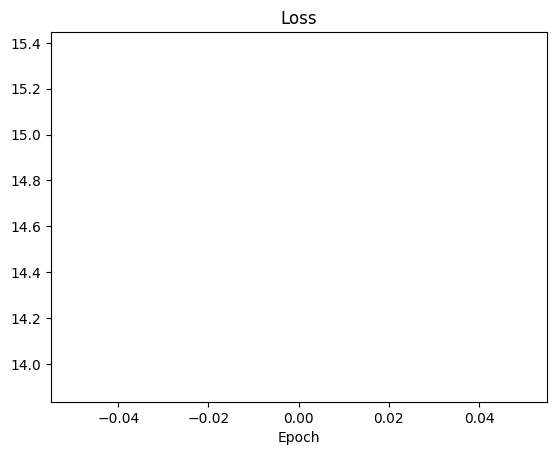

In [ ]:
plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("Epoch")

# Evaluation

Running model on validation dataset

In [ ]:
val_pred = {"val_images":[], "val_masks":[], "val_organs":[], "val_y_preds":[]}
for k, (val_image, val_organ, val_mask) in enumerate(train_dl):
    val_pred['val_images'].append(val_image)
    val_pred['val_mask'].append(val_mask)
    val_pred['val_organ'].append(val_organ)
    pred = MODEL(val_image)
    val_pred['val_y_preds'].append(pred)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\bapti\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bapti\AppData\Local\Temp\ipykernel_10600\2975505128.py", line 2, in <module>
    for k, (val_image, val_organ, val_mask) in enumerate(train_dl):
  File "c:\Users\bapti\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 628, in __next__
    data = self._next_data()
  File "c:\Users\bapti\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "c:\Users\bapti\miniconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\bapti\miniconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 58, in <listcomp>
    data = [self.dataset

In [ ]:
IoUs, IoUsOrgans = evaluation.get_y_true_y_pred(val_pred)

# Plot results for different threshold on all training and get best threshold
best_threshold = evaluation.plot_iou_by_threshold(IoUs, 'test')

AttributeError: module 'evaluation' has no attribute 'get_y_true_y_pred'

We can also look at some of the results

In [ ]:
evaluation.plot_validation_predictions(val_pred, best_threshold, 10)

# Submission

In [ ]:
test_dataset = None
submission.make_submission(MODEL, test_dataset, best_threshold)